# Setup

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging
import os

import numpy as np

from yass.neuralnet import NeuralNetDetector
from yass.config import Config

from neural_clustering.explore import (SpikeTrainExplorer,
                                       RecordingExplorer)
from neural_clustering import config


import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 15)

In [4]:
logging.basicConfig(level=logging.ERROR)

# Loading configuration files and YASS output

In [5]:
# load configuration files
cfg_yass = Config.from_yaml('../yass_config/local_7ch.yaml')
cfg = config.load('../config.yaml')

In [6]:
# load data generated from yass
files = ['score', 'clear_index', 'spike_times', 'spike_train', 'spike_left', 'templates']

(score, clear_index,
 spike_times, spike_train,
 spike_left, templates) = [np.load(os.path.join(cfg['root'], 'yass/{}.npy'.format(f))) for f in  files]

In [7]:
score.shape, clear_index.shape, spike_times.shape, spike_left.shape, templates.shape

((7,), (7,), (7,), (7,), (7, 31, 21))

# Loading raw recordings, geometry file and projection matrix

In [8]:
# load standarized recordings (these are raw recordings + filter + standarization)
path_to_recordings = os.path.join(cfg_yass.root, 'tmp/standarized.bin')
# load gemetry file (position for every electro)
path_to_geometry = os.path.join(cfg_yass.root, cfg_yass.geomFile)

In [9]:
# load projection matrix (to reduce dimensionality)
proj = NeuralNetDetector(cfg_yass).load_w_ae()

# Load clustering results and clear spike times

In [117]:
def relevel_clusters(clusters):
    group_ids = np.unique(clusters)
    groups = len(group_ids)
    mapping = {k: v for k,v in zip(group_ids, range(groups))}
    return np.array([mapping[k] for k in clusters])

In [118]:
clusters = relevel_clusters(np.load(os.path.join(cfg['root'], 'sessions/clusters.npy')))
clear_spikes = np.load(os.path.join(cfg['root'], 'clear_spikes.npy'))
results = np.vstack([clear_spikes, clusters]).T
group_ids = np.unique(clusters)

In [119]:
np.unique(clusters, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([162,   3, 606, 217, 171,   1, 456, 260]))

# Initializing explorers

In [120]:
# initialize explorers, these objects implement functions for plotting
# the output from YASS
explorer_rec = RecordingExplorer(path_to_recordings,
                                 path_to_geometry,
                                 dtype='float64',
                                 window_size=cfg_yass.spikeSize,
                                 n_channels=cfg_yass.nChan,
                                 neighbor_radius=cfg_yass.spatialRadius)

explorer_train = SpikeTrainExplorer(templates,
                                    results,
                                    explorer_rec,
                                    proj)

# Waveform plots

In [121]:
def make_template(group_id):
    wfs = explorer_train.waveforms_for_group(group_id=group_id, channels=range(7))
    return np.average(wfs, axis=0)

In [122]:
templates_new = np.stack([make_template(group_id) for group_id in group_ids]).transpose(2, 1, 0)

In [123]:
explorer_train = SpikeTrainExplorer(templates_new,
                                    results,
                                    explorer_rec,
                                    proj)

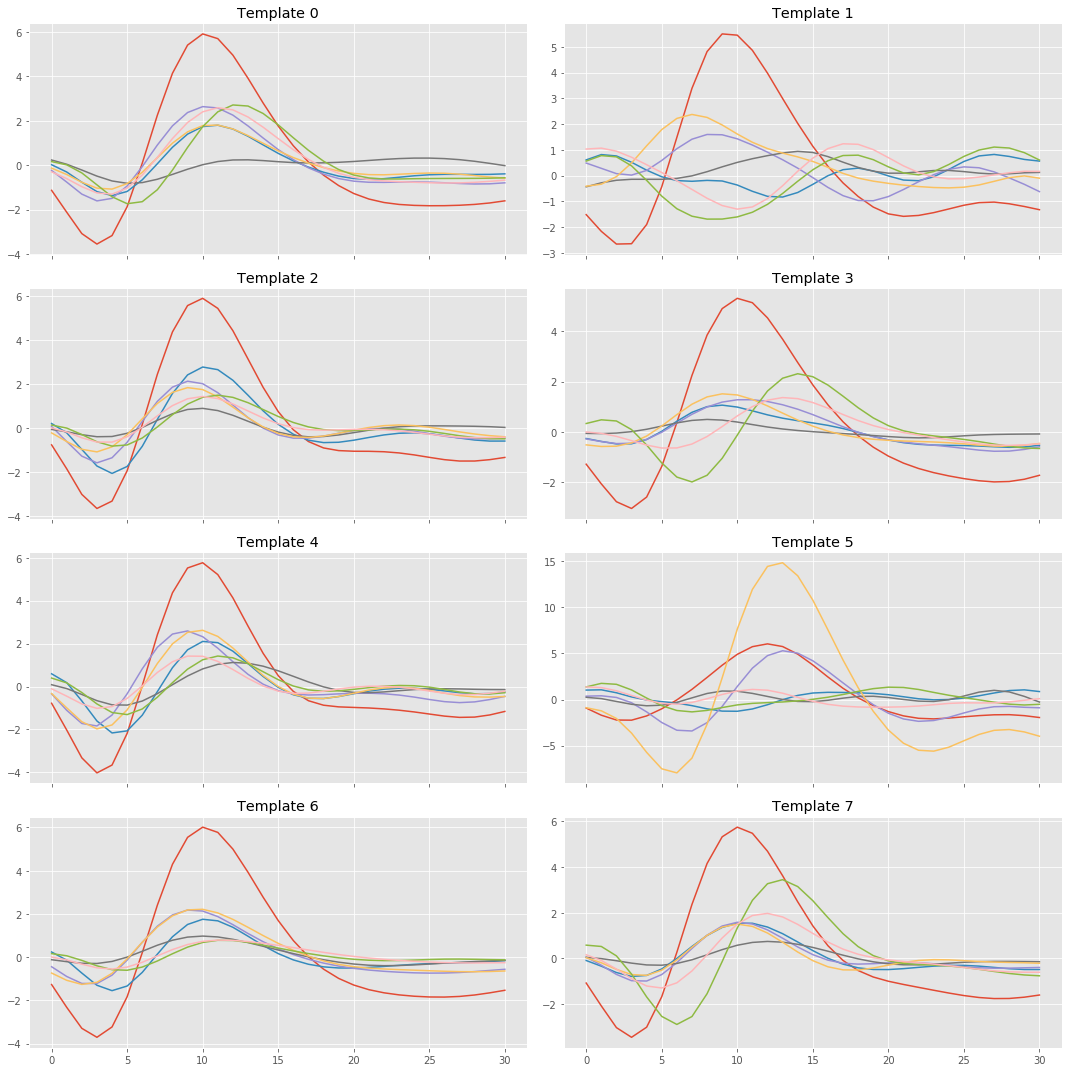

In [130]:
plt.rcParams['figure.figsize'] = (15, 15)
explorer_train.plot_templates(group_ids=group_ids)

## Cluster plots

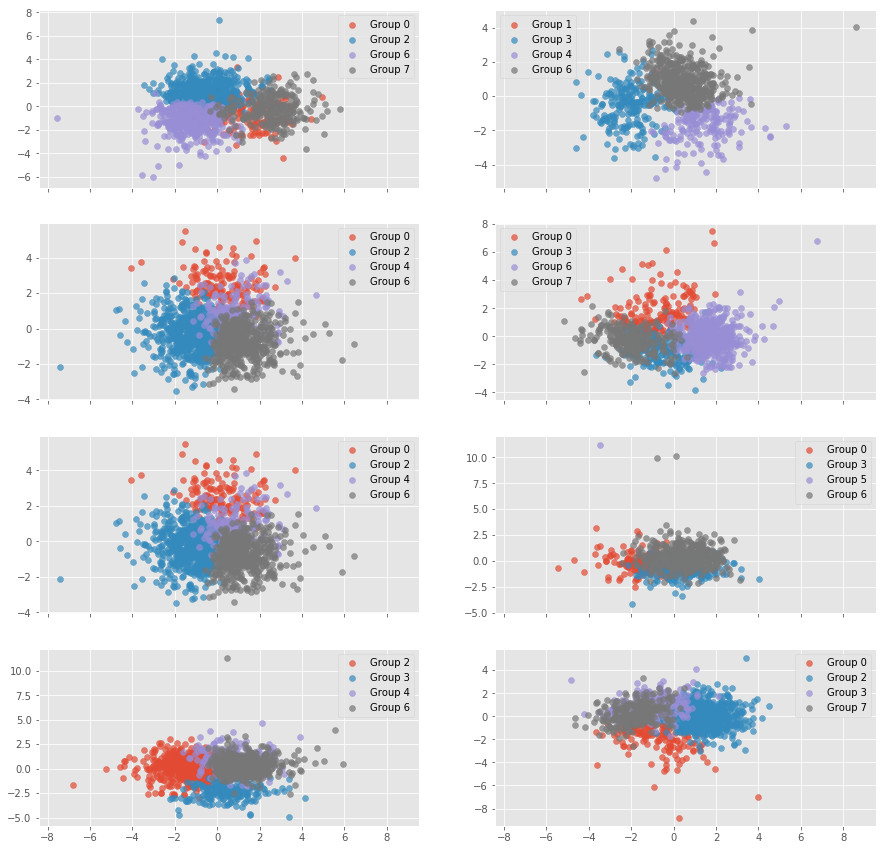

In [133]:
plt.rcParams['figure.figsize'] = (15, 15)
explorer_train.plot_all_clusters(k=3)

## Plotting specific groups

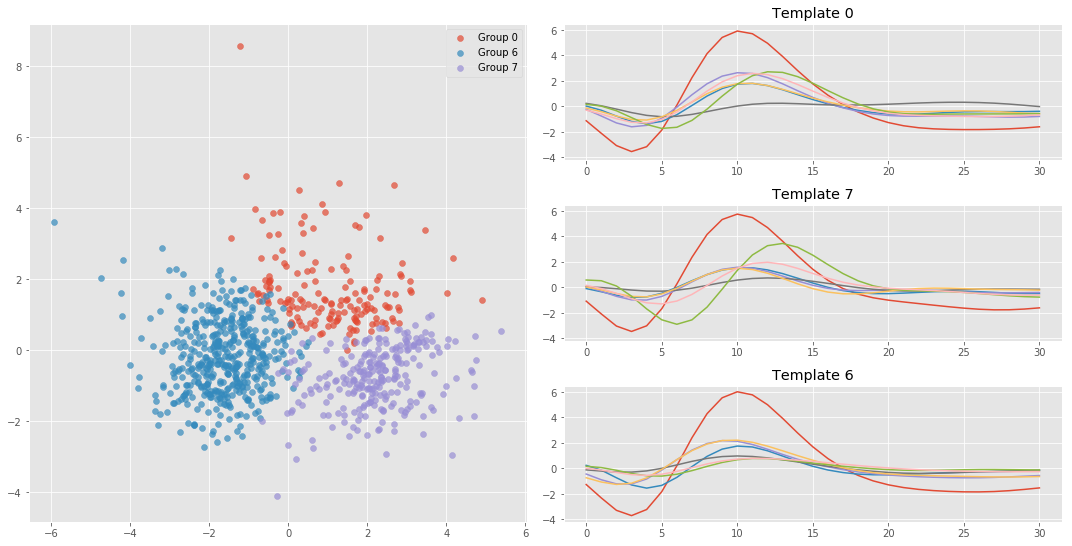

In [134]:
explorer_train.plot_waveforms_and_clusters(group_id=0)